<a href="https://colab.research.google.com/github/Fabkres/ArtificialIntelligence/blob/main/Rede_SOM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Implementação da rede SOM - Self-Organizing Maps

In [ ]:
import matplotlib.pylab as plt
import numpy as np
import gzip
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
import cv2

%matplotlib inline

In [ ]:
class SOM:
    # Inicialização
    def __init__(self, m, n, model=None, net_dim=(30, 30), learning_rate=0.5, iterations=100, n_classes = 10):
        if model is None:
            model = np.random.random((net_dim[0], net_dim[1], m))*0.01
        self.model = model
        self.net_dim = net_dim
        self.learning_rate = learning_rate
        self.iterations = iterations
        self.init_radius = np.average(np.array(net_dim)) / 2
        self.m = m
        self.n = n
        self.n_classes = n_classes
        self.time_constant = iterations / np.log(self.init_radius)
        self.labels = np.zeros((self.model.shape[0], self.model.shape[1], self.n_classes))

    # Processo Competitivo
    def fittest_neuron(self, feature):
        """
        	Encontrar o neurônio mais próximo w.r.t. características de entrada dadas x e modelo

         	:return: o neurônio e seu índice no modelo.
        """
        # calcule a distância entre cada neurônio e a entrada usando operação vetorizada
        distance = np.sqrt(np.sum((self.model - feature) ** 2, axis=2))
        pos = np.unravel_index(np.argmin(distance, axis=None), distance.shape)
        return (self.model[pos], pos)
    
    # Processo Cooperativo
    def decay_radius(self, i):
        return self.init_radius * np.exp(-i / self.time_constant)

    def decay_learning_rate(self, i):
        return self.learning_rate * np.exp(-i / self.iterations)

    # vizinhança gaussiana (dij)=h)
    def h(self, distance, radius):
        return np.exp(-distance / (2* (radius**2)))

    # Processo Adaptativo
    def train(self, x_train):
        zx = np.arange(0, self.net_dim[0], 1)
        zy = np.arange(0, self.net_dim[1], 1)
        zx, zy = np.meshgrid(zx,zy, indexing='ij')
        mesh_init = np.array([zx, zy])

        for i in range(self.iterations):
            # sample = x_train[np.random.randint(0, n, 1)]
            for feature in x_train:

                # encontre o mais apto
                fittest, fittest_idx = self.fittest_neuron(feature)
            
                # decair/reduzir os parâmetros do SOM
                r = self.decay_radius(i)
                l = self.decay_learning_rate(i)
            
                # atualizar o vetor de peso
                mesh_init[0] = mesh_init[0] - fittest_idx[0]
                mesh_init[1] = mesh_init[1] - fittest_idx[1]
                mesh = np.sqrt(np.sum(mesh_init ** 2, axis=0))
                neighbor_mask = mesh < r
                if len(neighbor_mask.flatten()) > 0:
                    mesh[neighbor_mask] = self.h(mesh[neighbor_mask], r)
                    self.model[neighbor_mask] = self.model[neighbor_mask] + l * np.multiply(mesh[neighbor_mask][:, np.newaxis], (feature - self.model)[neighbor_mask])   
    
    def error(self, x):
        distances = np.empty((x.shape[0],))
        for idx, feature in enumerate(x):
            fittest, fittest_idx = self.fittest_neuron(feature)
            distances[idx] = ((fittest - feature) ** 2).sum()
        return distances.mean()

    def label_neurons(self, x_train, y_train):
        # Eliminando os dados de treinamento e selecionando o neurônio vencedor
        for idx, feature in enumerate(x_train):
            distance = np.sqrt(np.sum((self.model - feature) ** 2, axis=2))
            pos = np.unravel_index(np.argmin(distance, axis=None), distance.shape)
            self.labels[pos[0], pos[1], y_train[idx]] += 1
        self.labels = np.argmax(self.labels, axis=2)
        return self.labels

    def accuracy(self, x_test, y_test):
        t = 0
        for idx, feature in enumerate(x_test):
            distance = np.sqrt(np.sum((self.model - feature) ** 2, axis=2))
            pos = np.unravel_index(np.argmin(distance, axis=None), distance.shape)
            if self.labels[pos[0], pos[1]] == y_test[idx]:
                t += 1
        return t / len(y_test)

    def visualize_map(self, x_test, y_test):
        wmap = {}
        im = 0
        for x, t in zip(x_test[:1000], y_test[:1000]):
            distance = np.sqrt(np.sum((self.model - x) ** 2, axis=2))
            pos = np.unravel_index(np.argmin(distance, axis=None), distance.shape)
            wmap[pos] = im
            plt.text(pos[0],  pos[1],  str(t), color=plt.cm.rainbow(t / 10.), fontdict={'weight': 'bold',  'size': 11})
            im = im + 1
        plt.axis([0, self.model.shape[0], 0,  self.model.shape[1]])
        plt.show()

    def visualize_u_matrix(self):
        u_matrix = np.zeros((self.model.shape[0], self.model.shape[1]))

        for i in range(self.model.shape[0]):
            for j in range(self.model.shape[1]):
                neighbors = []
                if i > 0:
                    neighbors.append(self.model[i - 1, j])
                if i < self.model.shape[0] - 1:
                    neighbors.append(self.model[i + 1, j])
                if j > 0:
                    neighbors.append(self.model[i, j - 1])
                if j < self.model.shape[1] - 1:
                    neighbors.append(self.model[i, j + 1])

                u_matrix[i, j] = np.mean(np.linalg.norm(neighbors - self.model[i, j], axis=1))

        plt.imshow(u_matrix, cmap='hot', interpolation='nearest')
        plt.colorbar()
        plt.title('U-Matrix')
        plt.show()



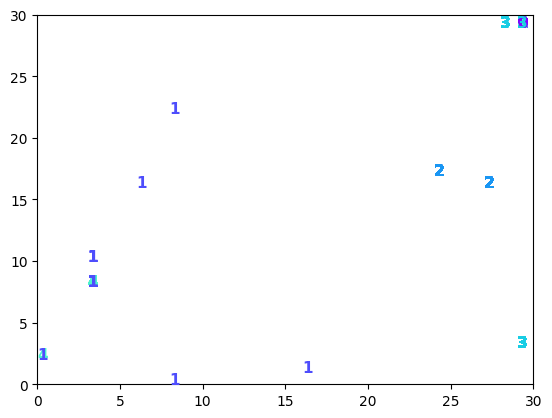

In [ ]:
from sklearn.datasets import make_blobs


X, y = make_blobs(n_samples=1000, centers=5, random_state=42)


m = X.shape[1]  # número de característica
n = X.shape[0]  # número de amostras
kohonen = SOM(m=m, n=n, net_dim=(30, 30))

# Treinando a rede SOM
kohonen.train(X)

# Visualizando o mapa treinado
kohonen.visualize_map(X, y)

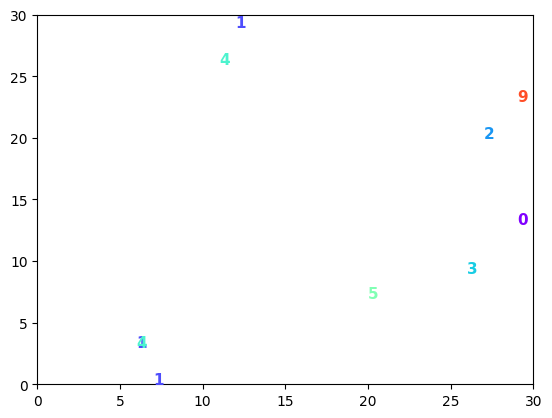

In [ ]:
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import MinMaxScaler

# Carregar dados MNIST
mnist = fetch_openml('mnist_784',parser='auto')
X = mnist.data.astype(float)
y = mnist.target.astype(int)

# Normalizar os dados
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Reduzir o conjunto de dados para poucos dados (opcional)
n_samples = 10
X = X[:n_samples]
y = y[:n_samples]

# Definir as dimensões de entrada e o número de classes
input_dim = X.shape[1]
n_classes = len(np.unique(y))

# Criar uma instância da classe SOM
kohonen = SOM(input_dim, n_classes)

# Treinar a rede
kohonen.train(X)

# Rotular os neurônios vencedores
labels = kohonen.label_neurons(X, y)

# Calcular a precisão da rede
accuracy = kohonen.accuracy(X, y)

# Visualizar o mapa
kohonen.visualize_map(X, y)


In [ ]:
accuracy

0.8

###Usando a base de dados wines com a biblioteca MiniSom

In [ ]:
!pip install MiniSom
from google.colab import drive
drive.mount('/content/drive')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Mounted at /content/drive


In [ ]:
from minisom import MiniSom
import pandas as pd

base = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/wines.csv')

X = base.iloc[:,1:14].values
y = base.iloc[:,0].values

from sklearn.preprocessing import MinMaxScaler
normalizador = MinMaxScaler(feature_range = (0,1))
X = normalizador.fit_transform(X)

som = MiniSom(x = 8, y = 8, input_len = 13, sigma = 1.0, learning_rate = 0.5, random_seed = 2)
som.random_weights_init(X)
som.train_random(data = X, num_iteration = 100)

som._weights
som._activation_map
q = som.activation_response(X)

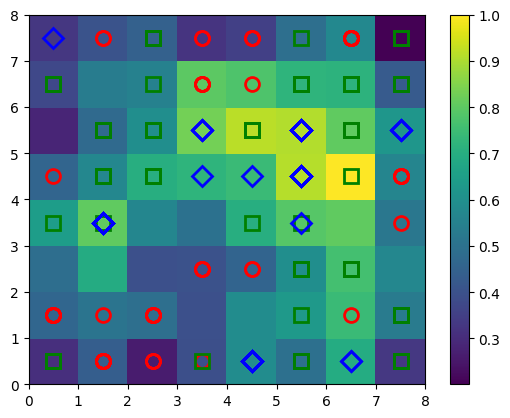

In [ ]:

from pylab import pcolor, colorbar, plot
pcolor(som.distance_map().T)
# MID - mean inter neuron distance
colorbar()

w = som.winner(X[2])
markers = ['o', 's', 'D']
color = ['r', 'g', 'b']
y[y == 1] = 0
y[y == 2] = 1
y[y == 3] = 2

for i, x in enumerate(X):
    #print(i)
    #print(x)
    w = som.winner(x)
    #print(w)
    plot(w[0] + 0.5, w[1] + 0.5, markers[y[i]],
         markerfacecolor = 'None', markersize = 10,
         markeredgecolor = color[y[i]], markeredgewidth = 2)

#-----------------------------Estudo de caso--------------------------------
https://www.youtube.com/watch?v=ogRu-JBRoyk&t=535s&ab_channel=RafaelCunha

#Dados de ansiedade em jogos on-line

###Pesquisa feita sobre jogos e sua associação com ansiedade, satisfação com a vida e fobia social

Este conjunto de dados consiste em dados coletados como parte de uma pesquisa entre jogadores de todo o mundo. O questionário fazia perguntas que os psicólogos geralmente fazem às pessoas propensas à ansiedade, fobia social e pouca ou nenhuma satisfação com a vida. O questionário consiste em vários conjuntos de perguntas feitas como parte do estudo psicológico. Os dados originais foram compilados por Marian Sauter e Dejan Draschkow.

https://www.kaggle.com/datasets/divyansh22/online-gaming-anxiety-data


*O arquivo é composto por 55 colunas que correspondem a todas as perguntas feitas no questionário. A maioria das colunas corresponde a diferentes critérios de pontuação usados ​​em psicologia, como pontuações GAD (Transtorno de Ansiedade Geral), SWL (Satisfação com a Vida) e SPIN (Inventário de Fobia Social). Existem algumas perguntas genéricas sobre onde as pessoas nascem e por que jogam jogos online etc.*

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()

In [3]:
from google.colab import drive
drive.mount('/content/drive')
file = '/content/drive/MyDrive/Colab Notebooks/GamingStudy_data.csv'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
# Determinando qual o character encoding
import chardet
with open(file, 'rb') as rawdata:
    result = chardet.detect(rawdata.read(100000))
result
dataset = pd.read_csv(file, encoding='ISO-8859-1') 
# Preenchendo valores NaN por zeros
dataset = dataset.fillna(0)
dataset

,S. No.,Timestamp,GAD1,GAD2,GAD3,GAD4,GAD5,GAD6,GAD7,GADE,...,Birthplace,Residence,Reference,Playstyle,accept,GAD_T,SWL_T,SPIN_T,Residence_ISO3,Birthplace_ISO3
0,1,42052.00437,0,0,0,0,1,0,0,Not difficult at all,...,USA,USA,Reddit,Singleplayer,Accept,1,23,5.0,USA,USA
1,2,42052.00680,1,2,2,2,0,1,0,Somewhat difficult,...,USA,USA,Reddit,Multiplayer - online - with strangers,Accept,8,16,33.0,USA,USA
2,3,42052.03860,0,2,2,0,0,3,1,Not difficult at all,...,Germany,Germany,Reddit,Singleplayer,Accept,8,17,31.0,DEU,DEU
3,4,42052.06804,0,0,0,0,0,0,0,Not difficult at all,...,USA,USA,Reddit,Multiplayer - online - with online acquaintanc...,Accept,0,17,11.0,USA,USA
4,5,42052.08948,2,1,2,2,2,3,2,Very difficult,...,USA,South Korea,Reddit,Multiplayer - online - with strangers,Accept,14,14,13.0,KOR,USA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13459,14246,42057.75678,1,0,0,1,0,1,1,Not difficult at all,...,France,France,Reddit,Multiplayer - online - with strangers,Accept,4,28,7.0,FRA,FRA
13460,14247,42057.81185,3,3,3,3,2,3,3,Extremely difficult,...,USA,USA,Reddit,Multiplayer - online - with strangers,Accept,20,23,25.0,USA,USA
13461,14248,42058.16964,0,0,0,0,0,0,0,Not difficult at all,...,Norway,Norway,Reddit,Multiplayer - online - with real life friends,Accept,0,32,10.0,NOR,NOR
13462,14249,42058.24420,3,2,1,3,0,1,3,Somewhat difficult,...,Canada,Canada,Reddit,Singleplayer,Accept,13,16,32.0,CAN,CAN


In [8]:
# Instalando a MiniSOM
!pip install minisom

from minisom import MiniSom

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for minisom: filename=MiniSom-2.3.1-py3-none-any.whl size=10589 sha256=edaa3568932dccd41d78aebb1f5c61c9f1431c17c426376953c31d6db91df513
  Stored in directory: /root/.cache/pip/wheels/c7/92/d2/33bbda5f86fd8830510b16aa98c8dd420129b5cb24248fd6db
Successfully built minisom


In [10]:
# treinamento da rede SOM - retorna os pesos da rede 
def treinaRedeSOM(X, tamanhoXdaRede, tamanhoYdaRede, quantidadeCaracteristicas, qtIteracoes ):
  som = MiniSom(x = tamanhoXdaRede, y = tamanhoYdaRede, input_len = quantidadeCaracteristicas, sigma = 1.0, learning_rate = 0.4)
  som.pca_weights_init(X)
  som.train_random(data = X, num_iteration = qtIteracoes)
  return som

# Mostra os perfis encontrados
def mostraPesos(pesos, quantidadeCaracteristicas, tamanhoXdaRede, tamanhoYdaRede, alturaPlot = 1):
  cont = 1;
  x = np.arange(quantidadeCaracteristicas)
  for row in pesos:
    for elem in row:
      plt.subplot(tamanhoXdaRede,tamanhoYdaRede,cont)
      cont=cont+1
      plt.axis([-1, quantidadeCaracteristicas, 0, alturaPlot])
      plt.bar(x, elem)
  plt.xlabel('Transtorno de Ansiedade Geral/Fobia Social')
  plt.show()

# Gera as matrizes com o número total de pessoas em um perfil e seus scores de satisfação com a vida (swl)
def matrizes(profile, SOMprofile, profileSWL):
  Msat = np.zeros((3,3))
  Mtot = np.zeros((3,3))
  cont = 0

  for x in profile:
    pos = SOMprofile.winner(x)
    if (profileSWL[cont] >= 21):
      Msat[pos] += 1
    Mtot[pos] += 1
    cont= cont+1
  
  return [Msat, Mtot]

# Plota o perfil de satisfação com a vida da matriz analisada
def plotSatisfactionProfiles(Mtotal, Msatisfaction):
  cont = 1

  for i in range(len(Mtotal)):
    for j in range(len(Mtotal)):
      plt.subplot(3,3,cont)
      cont=cont+1
      sizes = [Msatisfaction[i][j],Mtotal[i][j]-Msatisfaction[i][j]]
      plt.pie(sizes)
  
  plt.xlabel('Satisfeitos em azul')
  plt.show()
# Retorna a porcentagem da pessoas satisfeitas com a vida de um perfil
def swlPercent(profileSWL):
  satisf = 0
  total = 0
  for x in profileSWL:
    if (x >= 21):
      satisf += 1
    total +=1
  porcentagem = (satisf*100)/total
  return round(porcentagem)

# Retorna a porcentagem dos ansiosos em um perfil
def gadPercent(profileGAD):
  anx = 0
  total = 0
  for x in profileGAD:
    if (x >= 7):
      anx += 1
    total +=1
  porcentagem = (anx*100)/total
  return round(porcentagem)

# Retorna a porcentagem de quem apresenta fobia social em um perfil
def spinPercent(profileSPIN):
  sphobia = 0
  total = 0
  for x in profileSPIN:
    if (x >= 25):
      sphobia += 1
    total +=1
  porcentagem = (sphobia*100)/total
  return round(porcentagem)

GAD scores: 5 (leve) / 10 (moderada) / 15 (severa)

SWL scores:  5-9 (extremamente insatisfeito) / 20 (neutro) / 31-35 (extremamente satisfeito)

SPIN score: 21-30 (leve) / 31-40 (moderada) / 41-50 (severa) / 50-68 (muito severa)

# Tendências da pesquisa:
O número de homens na pesquisa é 17x maior que o de mulheres entrevistadas

In [13]:
genero = dataset.groupby(['Gender']).count() 
genero = genero.iloc[:,0]
print(genero)

Gender
Female      713
Male      12699
Other        52
Name: S. No., dtype: int64


*Grande* parte dos entrevistados tem idade entre 18-23 anos

In [17]:
idade = dataset.groupby(['Age']).count() 
idade = idade.iloc[:,0]
print(idade)
idade.shape

Age
18    3588
19    2159
20    1855
21    1507
22    1135
23     872
24     660
25     514
26     338
27     231
28     157
29     119
30      89
31      58
32      53
33      37
34      19
35      17
36      16
37       5
38       8
39       6
40       3
41       4
42       6
44       2
49       1
50       3
56       1
63       1
Name: S. No., dtype: int64


(30,)

Quase todos os entrevistados jogam pelo computador

In [18]:
ps = dataset.groupby(['Platform']).count()
ps = ps.iloc[:,0]
ps

Platform
Console (PS, Xbox, ...)      222
PC                         13219
Smartphone / Tablet           23
Name: S. No., dtype: int64

A maioria dos entrevistados jogam League of Legends

In [19]:
game = dataset.groupby(['Game']).count()
game = game.iloc[:,0]
game

Game
Counter Strike           318
Destiny                   18
Diablo 3                  89
Guild Wars 2              37
Hearthstone              101
Heroes of the Storm       41
League of Legends      11314
Other                   1021
Skyrim                    28
Starcraft 2              345
World of Warcraft        152
Name: S. No., dtype: int64

### Analisando pessoas que têm dificuldade em não jogar durante o trabalho

In [20]:
easy = dataset[dataset['GADE'].str.contains("Not difficult at all", na=False)]
easySWL = easy.iloc[:,51].values
easyGAD = easy.iloc[:,50].values
easySPIN = easy.iloc[:,52].values
easy = easy.iloc[:,[50,52]].values

medium = dataset[dataset['GADE'].str.contains("Somewhat difficult", na=False)]
mediumSWL = medium.iloc[:,51].values
mediumGAD = medium.iloc[:,50].values
mediumSPIN = medium.iloc[:,52].values
medium = medium.iloc[:,[50,52]].values

hard = dataset[dataset['GADE'].str.contains("Very difficult", na=False) | dataset['GADE'].str.contains("Extremely difficult", na=False)]
hardSWL = hard.iloc[:,51].values
hardGAD = hard.iloc[:,50].values
hardSPIN = hard.iloc[:,52].values
hard = hard.iloc[:,[50,52]].values

Normalizando os dados:

In [23]:
hard = sc.fit_transform(hard)
medium = sc.fit_transform(medium)
easy = sc.fit_transform(easy)

###Treinando a rede SOM

In [26]:
[roww, coll] = easy.shape
[row, col] = hard.shape
[rw, cl] = medium.shape

somES = treinaRedeSOM(easy,3,3,coll,80000)
somHD = treinaRedeSOM(hard,3,3,col,80000) 
somMD = treinaRedeSOM(medium,3,3,cl,80000) 

# Analisando os dados
[MeasyS, MeasyT] = matrizes(easy, somES, easySWL)
[MhardS, MhardT] = matrizes(hard, somHD, hardSWL)
[MmediumS, MmediumT] = matrizes(medium, somMD, mediumSWL)

Pessoas que não têm dificuldade em não jogar no trabalho:

Perfil SOM com dados de ansiedade e fobia social:
Ansiosos: 10 % Apresentam Fobia Social: 19 %


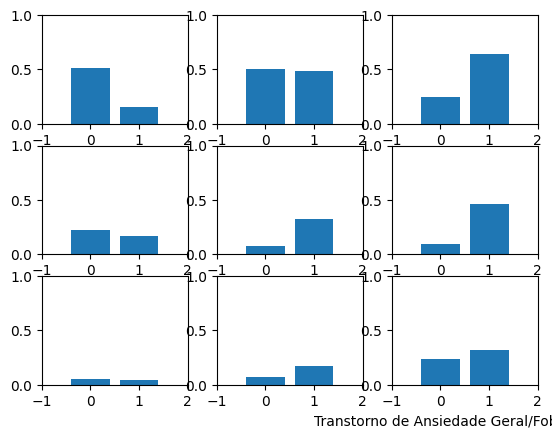

Satisfação com a vida de pessoas que acham fácil não jogar no trabalho:
Total:  59 %


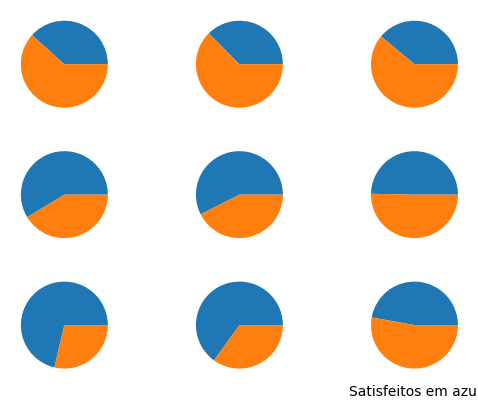

In [29]:
print('Perfil SOM com dados de ansiedade e fobia social:')
print("Ansiosos:",gadPercent(easyGAD),"%","Apresentam Fobia Social:",spinPercent(easySPIN),"%")
mostraPesos(somES.get_weights(), coll, 3,3 )
print('Satisfação com a vida de pessoas que acham fácil não jogar no trabalho:')
easyP = swlPercent(easySWL)
print("Total: ",easyP,"%")
plotSatisfactionProfiles(MeasyT, MeasyS)

Pessoas que têm muita dificuldade em não jogar durante o trabalho:

Perfil SOM com dados de anxiedade e fobia social:
Ansiosos: 85 % Apresentam Fobia Social: 59 %


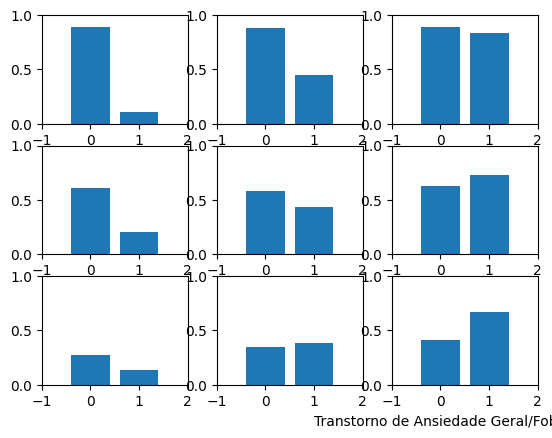

SWL de pessoas que acham difícil não jogar no trabalho:
Total:  15 %


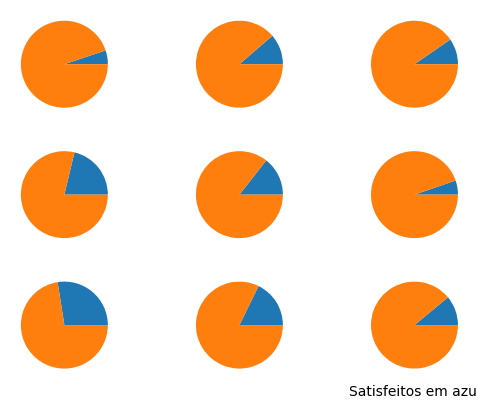

In [30]:
print('Perfil SOM com dados de anxiedade e fobia social:')
print("Ansiosos:",gadPercent(hardGAD),"%","Apresentam Fobia Social:",spinPercent(hardSPIN),"%")
mostraPesos(somHD.get_weights(), col, 3,3 )
print('SWL de pessoas que acham difícil não jogar no trabalho:')
hardP = swlPercent(hardSWL)
print("Total: ",hardP,"%")
plotSatisfactionProfiles(MhardT, MhardS)

Pessoas que tem pouca dificuldade em não jogar no trabalho:

Perfil SOM com dados de anxiedade e fobia social:
Ansiosos: 44 % Apresentam Fobia Social: 38 %


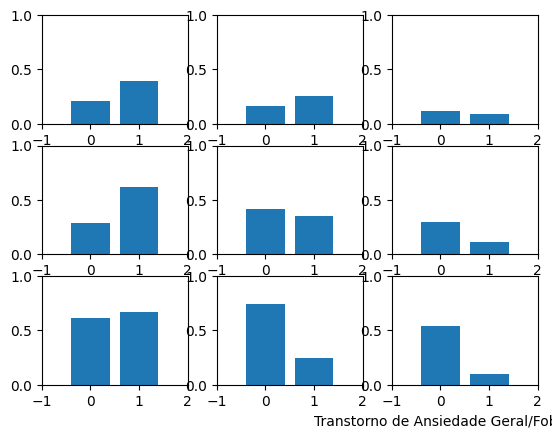

SWL de pessoas que apresentam um pouco de dificuldade em não jogar no trabalho:
Total:  39 %


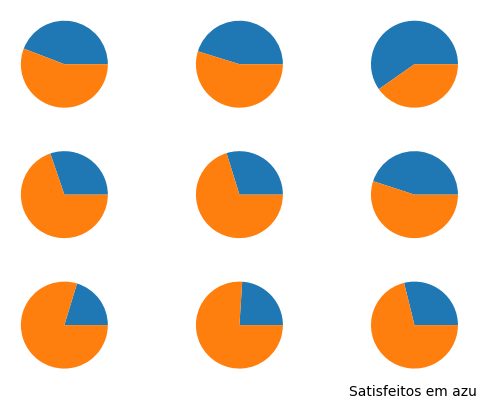

In [31]:
print('Perfil SOM com dados de anxiedade e fobia social:')
print("Ansiosos:",gadPercent(mediumGAD),"%","Apresentam Fobia Social:",spinPercent(mediumSPIN),"%")
mostraPesos(somMD.get_weights(), col, 3,3 )
print('SWL de pessoas que apresentam um pouco de dificuldade em não jogar no trabalho:')
mediumP = swlPercent(mediumSWL)
print("Total: ",mediumP,"%")
plotSatisfactionProfiles(MmediumT, MmediumS)

#Analisando de acordo com o motivo de jogar
Dados confusos, com muitas respostas misturadas:

In [33]:
wp = dataset.groupby("whyplay").count()
wp = wp.iloc[:,0]
print(wp)

improving = dataset[dataset['whyplay'].str.contains("improving", na=False)]
improvingSWL = improving.iloc[:,51].values
improving = improving.iloc[:,[50,52]].values

winning = dataset[dataset['whyplay'].str.contains("winning", na=False)]
winningSWL = winning.iloc[:,51].values
winning = winning.iloc[:,[50,52]].values

having_fun = dataset[dataset['whyplay'].str.contains("having fun", na=False)]
having_funSWL = having_fun.iloc[:,51].values
having_fun = having_fun.iloc[:,[50,52]].values

relaxing = dataset[dataset['whyplay'].str.contains("relaxing", na=False)]
relaxingSWL = relaxing.iloc[:,51].values
relaxing = relaxing.iloc[:,[50,52]].values

whyplay
1. Having fun 2. winning 3. improving 4. relaxing (all in a bit)                                                  1
A combination of fun (with friends,) and improving (in competitive)                                               1
A combination of winning, improving, and having fun.  I don't regret playing if we don't win or make mistakes.    1
A little bit of both to be honest. I play because its fun, but I prefer winning over losing obviously.            1
A mix between fun, improviment and winning                                                                        1
                                                                                                                 ..
winning, improving and having fun                                                                                 1
winning, while having fun                                                                                         1
winning/having fun                                              

Normalizando e treinando

In [34]:
improving = sc.fit_transform(improving)
winning = sc.fit_transform(winning)
having_fun = sc.fit_transform(having_fun)
relaxing = sc.fit_transform(relaxing)

# Treinando
[roww, coll] = improving.shape
[row, col] = winning.shape
[rw, cl] = having_fun.shape
[rows, cols] = relaxing.shape

somIM = treinaRedeSOM(improving,3,3,coll,80000)
somWI = treinaRedeSOM(winning,3,3,col,80000) 
somHF = treinaRedeSOM(having_fun,3,3,cl,80000) 
somRL = treinaRedeSOM(relaxing,3,3,cols,80000) 

### Visualizando dados

Satisfação com a vida de pessoas que jogam para se aperfeiçoar:


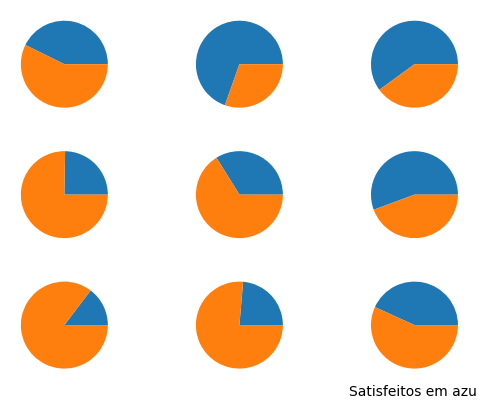

Perfil SOM com dados de anxiedade e fobia social:


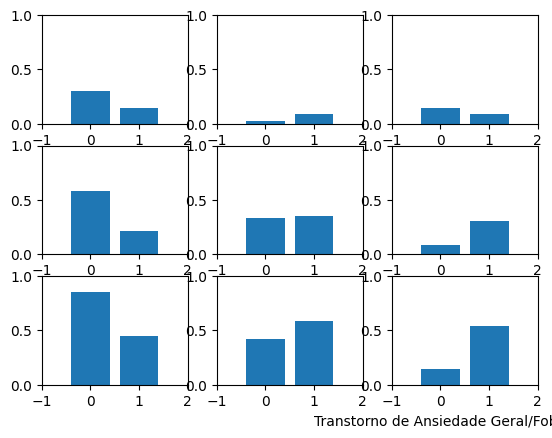

Satisfação com a vida de pessoas que jogam para ganhar:


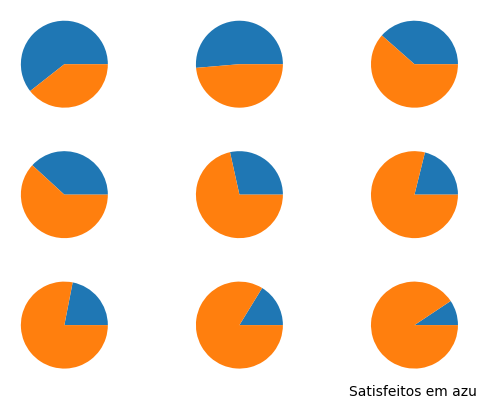

Perfil SOM com dados de anxiedade e fobia social:


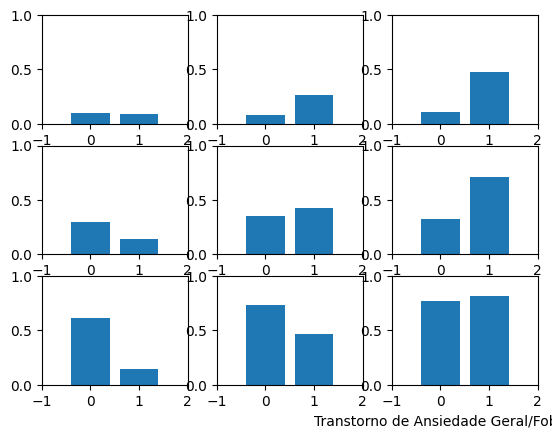

Satisfação com a vida de pessoas que jogam para se divertir:


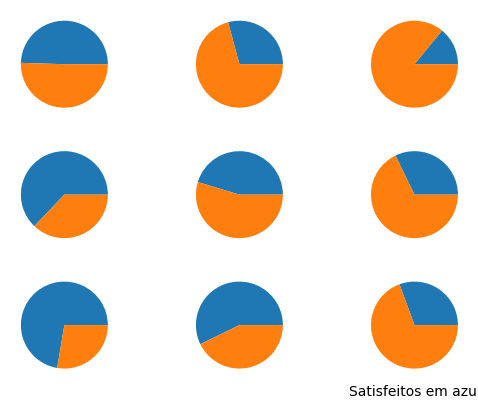

Perfil SOM com dados de anxiedade e fobia social:


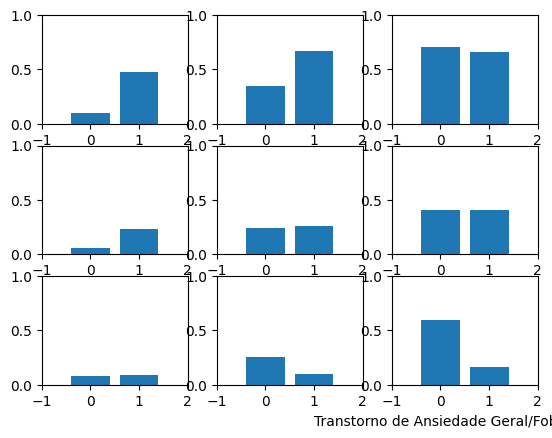

Satisfação com a vida de pessoas que jogam para relaxar:


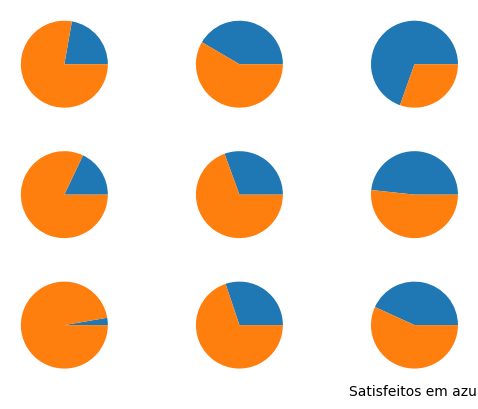

Perfil SOM com dados de anxiedade e fobia social:


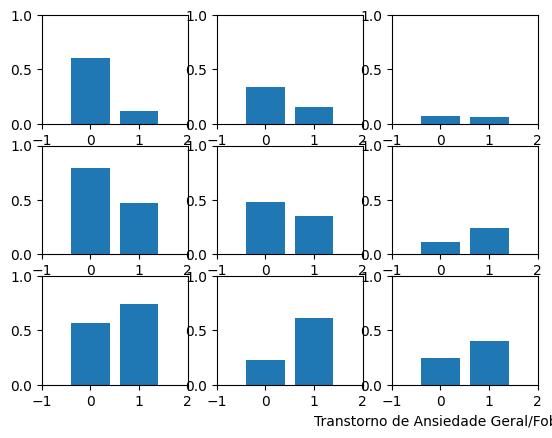

In [35]:
[MimprovingS, MimprovingT] = matrizes(improving, somIM, improvingSWL)
[MwinningS, MwinningT] = matrizes(winning, somWI, winningSWL)
[Mhaving_funS, Mhaving_funT] = matrizes(having_fun, somHF, having_funSWL)
[MrelaxingS, MrelaxingT] = matrizes(relaxing, somRL, relaxingSWL)

print('Satisfação com a vida de pessoas que jogam para se aperfeiçoar:')
plotSatisfactionProfiles(MimprovingT, MimprovingS)
print('Perfil SOM com dados de anxiedade e fobia social:')
mostraPesos(somIM.get_weights(), coll, 3,3 )

print('Satisfação com a vida de pessoas que jogam para ganhar:')
plotSatisfactionProfiles(MwinningT, MwinningS)
print('Perfil SOM com dados de anxiedade e fobia social:')
mostraPesos(somWI.get_weights(), col, 3,3 )

print('Satisfação com a vida de pessoas que jogam para se divertir:')
plotSatisfactionProfiles(Mhaving_funT, Mhaving_funS)
print('Perfil SOM com dados de anxiedade e fobia social:')
mostraPesos(somHF.get_weights(), cl, 3,3 )

print('Satisfação com a vida de pessoas que jogam para relaxar:')
plotSatisfactionProfiles(MrelaxingT, MrelaxingS)
print('Perfil SOM com dados de anxiedade e fobia social:')
mostraPesos(somRL.get_weights(), cols, 3,3 )

# Analisando de acordo com o trabalho do entrevistado

In [36]:
employed = dataset[dataset['Work'].str.contains("Employed", na=False)]
employedSWL = employed.iloc[:,51].values
employedGAD = employed.iloc[:,50].values
employedSPIN = employed.iloc[:,52].values
employed = employed.iloc[:,[50,52]].values

university = dataset[dataset['Work'].str.contains("Student at college / university", na=False)]
universitySWL = university.iloc[:,51].values
universityGAD = university.iloc[:,50].values
universitySPIN = university.iloc[:,52].values
university = university.iloc[:,[50,52]].values

school = dataset[dataset['Work'].str.contains("Student at school", na=False)]
schoolSWL = school.iloc[:,51].values
schoolGAD = school.iloc[:,50].values
schoolSPIN = school.iloc[:,52].values
school = school.iloc[:,[50,52]].values

unemployed = dataset[dataset['Work'].str.contains("Unemployed / between jobs", na=False)]
unemployedSWL = unemployed.iloc[:,51].values
unemployedGAD = unemployed.iloc[:,50].values
unemployedSPIN = unemployed.iloc[:,52].values
unemployed = unemployed.iloc[:,[50,52]].values

### Normalizando e treinando a rede SOM

In [37]:
employed = sc.fit_transform(employed)
unemployed = sc.fit_transform(unemployed)
university = sc.fit_transform(university)
school = sc.fit_transform(school)

[roww, coll] = employed.shape
[row, col] = unemployed.shape
[rw, cl] = university.shape
[rows, cols] = school.shape

somEP = treinaRedeSOM(employed,3,3,coll,80000)
somUP = treinaRedeSOM(unemployed,3,3,col,80000) 
somUN = treinaRedeSOM(university,3,3,cl,80000) 
somSC = treinaRedeSOM(school,3,3,cols,80000) 

### Visualizando os dados

In [40]:
[MemployedS, MemployedT] = matrizes(employed, somEP, employedSWL)
[MunemployedS, MunemployedT] = matrizes(unemployed, somUP, unemployedSWL)
[MuniversityS, MuniversityT] = matrizes(university, somUN, universitySWL)
[MschoolS, MschoolT] = matrizes(school, somSC, schoolSWL)


#####PESSOAS EMPREGADAS

Perfil SOM com dados de anxiedade e fobia social:
Ansiosos: 25 % Apresentam Fobia Social: 24 %


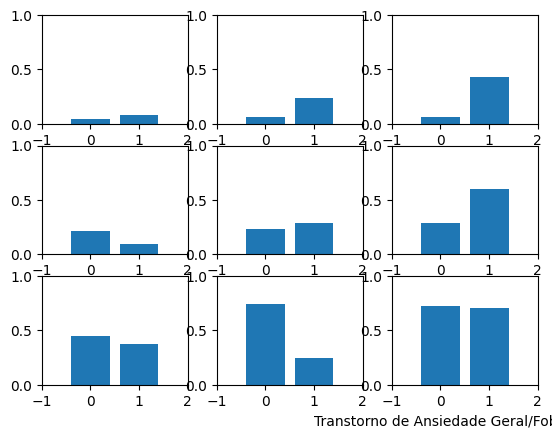

Satisfação com a vida de pessoas que estão empregadas:
Total:  52 %


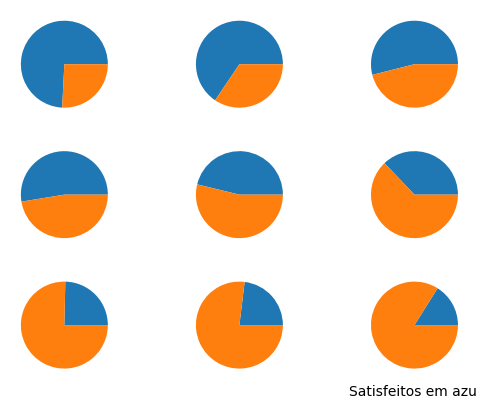

In [41]:
print('Perfil SOM com dados de anxiedade e fobia social:')
print("Ansiosos:",gadPercent(employedGAD),"%","Apresentam Fobia Social:",spinPercent(employedSPIN),"%")
mostraPesos(somEP.get_weights(), coll, 3,3 )
print('Satisfação com a vida de pessoas que estão empregadas:')
employedP = swlPercent(employedSWL)
print("Total: ",employedP,"%")
plotSatisfactionProfiles(MemployedT, MemployedS)


#####PESSOAS DESEMPREGADAS

Perfil SOM com dados de anxiedade e fobia social:
Ansiosos: 41 % Apresentam Fobia Social: 39 %


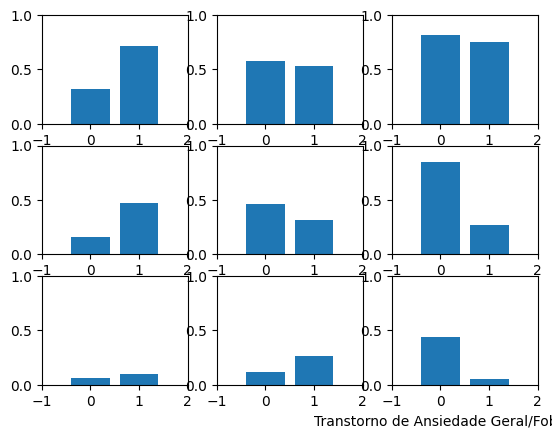

Satisfação com a vida de pessoas que estão desempregadas:
Total:  21 %


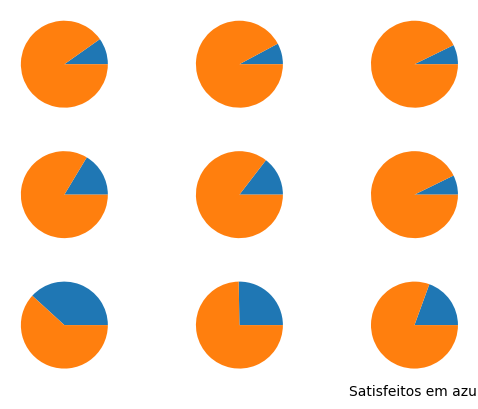

In [42]:
print('Perfil SOM com dados de anxiedade e fobia social:')
print("Ansiosos:",gadPercent(unemployedGAD),"%","Apresentam Fobia Social:",spinPercent(unemployedSPIN),"%")
mostraPesos(somUP.get_weights(), col, 3,3 )
print('Satisfação com a vida de pessoas que estão desempregadas:')
unemployedP = swlPercent(unemployedSWL)
print("Total: ",unemployedP,"%")
plotSatisfactionProfiles(MunemployedT, MunemployedS)

####Universitários

Perfil SOM com dados de anxiedade e fobia social:
Ansiosos: 31 % Apresentam Fobia Social: 30 %


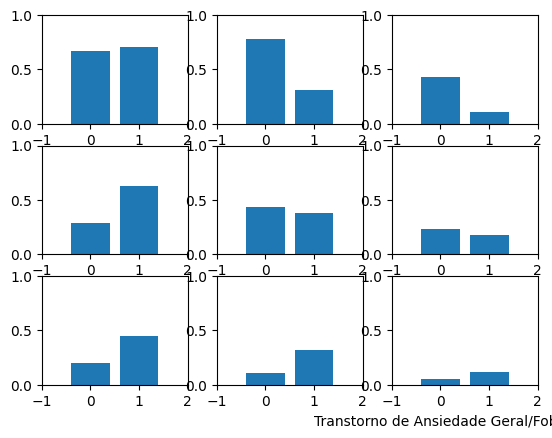

Satisfação com a vida de pessoas que estudam em universidades:
Total:  50 %


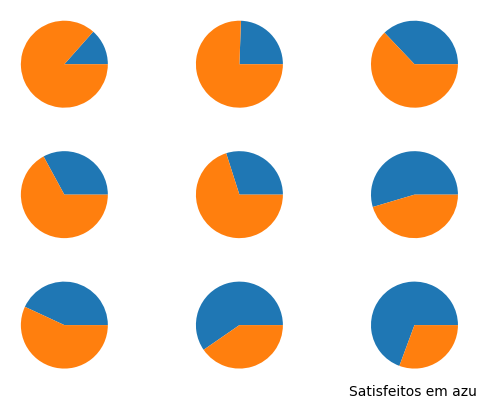

In [43]:
print('Perfil SOM com dados de anxiedade e fobia social:')
print("Ansiosos:",gadPercent(universityGAD),"%","Apresentam Fobia Social:",spinPercent(universitySPIN),"%")
mostraPesos(somUN.get_weights(), cl, 3,3 )
print('Satisfação com a vida de pessoas que estudam em universidades:')
universityP = swlPercent(universitySWL)
print("Total: ",universityP,"%")
plotSatisfactionProfiles(MuniversityT, MuniversityS)

####Estudantes do ensino médio

Perfil SOM com dados de anxiedade e fobia social:
Ansiosos: 32 % Apresentam Fobia Social: 34 %


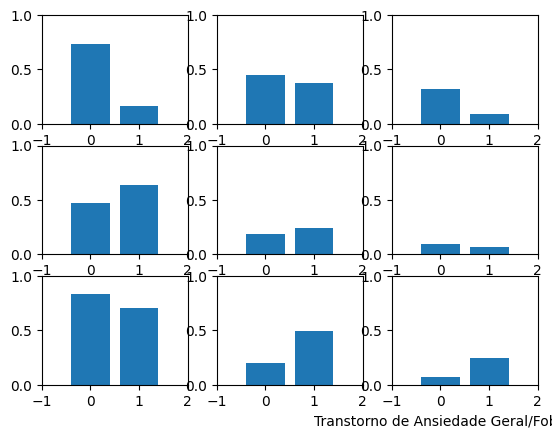

Satisfação com a vida de pessoas que estudam em escolas:
Total:  49 %


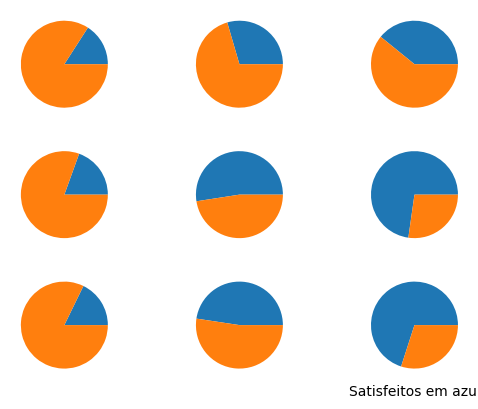

In [44]:
print('Perfil SOM com dados de anxiedade e fobia social:')
print("Ansiosos:",gadPercent(schoolGAD),"%","Apresentam Fobia Social:",spinPercent(schoolSPIN),"%")
mostraPesos(somSC.get_weights(), cols, 3,3 )
print('Satisfação com a vida de pessoas que estudam em escolas:')
schoolP = swlPercent(schoolSWL)
print("Total: ",schoolP,"%")
plotSatisfactionProfiles(MschoolT, MschoolS)

### Analisando de acordo com a formação acadêmica

In [45]:
bachelor = dataset[dataset['Degree'].str.contains("Bachelor", na=False)]
bachelorSWL = bachelor.iloc[:,51].values
bachelorGAD = bachelor.iloc[:,50].values
bachelorSPIN = bachelor.iloc[:,52].values
bachelor = bachelor.iloc[:,[50,52]].values

hschool = dataset[dataset['Degree'].str.contains("High school diploma", na=False)]
hschoolSWL = hschool.iloc[:,51].values
hschoolGAD = hschool.iloc[:,50].values
hschoolSPIN = hschool.iloc[:,52].values
hschool = hschool.iloc[:,[50,52]].values

master = dataset[dataset['Degree'].str.contains("Master", na=False)]
masterSWL = master.iloc[:,51].values
masterGAD = master.iloc[:,50].values
masterSPIN = master.iloc[:,52].values
master = master.iloc[:,[50,52]].values

degreenone = dataset[dataset['Degree'].str.contains("None", na=False)]
degreenoneSWL = degreenone.iloc[:,51].values
degreenoneGAD = degreenone.iloc[:,50].values
degreenoneSPIN = degreenone.iloc[:,52].values
degreenone = degreenone.iloc[:,[50,52]].values

phd = dataset[dataset['Degree'].str.contains("Ph.D., Psy. D., MD", na=False)]
phdSWL = phd.iloc[:,51].values
phdGAD = phd.iloc[:,50].values
phdSPIN = phd.iloc[:,52].values
phd = phd.iloc[:,[50,52]].values

Normalizando e treinando os dados

In [46]:
bachelor = sc.fit_transform(bachelor)
master = sc.fit_transform(master)
phd = sc.fit_transform(phd)
hschool = sc.fit_transform(hschool)
degreenone = sc.fit_transform(degreenone)

[roww, coll] = bachelor.shape
[row, col] = master.shape
[rw, cl] = phd.shape
[rows, cols] = hschool.shape
[rws, cls] = degreenone.shape

somBA = treinaRedeSOM(bachelor,3,3,coll,80000)
somMA = treinaRedeSOM(master,3,3,col,80000) 
somPD = treinaRedeSOM(phd,3,3,cl,80000) 
somHS = treinaRedeSOM(hschool,3,3,cols,80000)
somDN = treinaRedeSOM(degreenone,3,3,cls,80000) 

### Visualizando os dados

In [47]:
[MbachelorS, MbachelorT] = matrizes(bachelor, somBA, bachelorSWL)
[MmasterS, MmasterT] = matrizes(master, somMA, masterSWL)
[MphdS, MphdT] = matrizes(phd, somPD, phdSWL)
[MhschoolS, MhschoolT] = matrizes(hschool, somHS, hschoolSWL)
[MdegreenoneS, MdegreenoneT] = matrizes(degreenone, somDN, degreenoneSWL)

Bacharéis:

Perfil SOM com dados de anxiedade e fobia social:
Ansiosos: 27 % Apresentam Fobia Social: 24 %


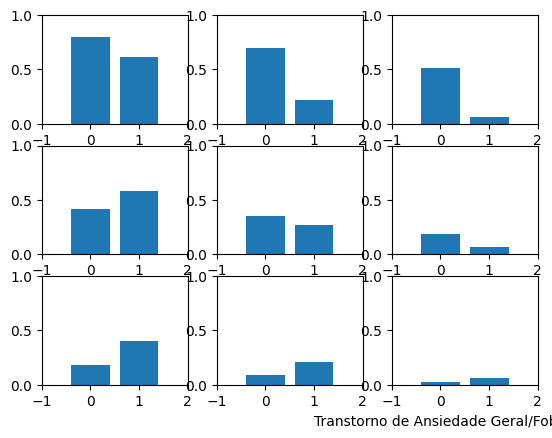

Satisfação com a vida de pessoas que possuem um bacharelado:
Total:  54 %


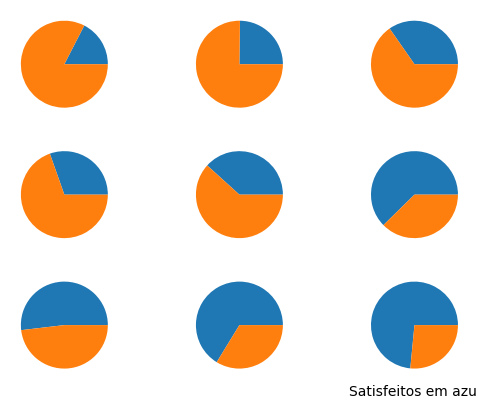

In [48]:
print('Perfil SOM com dados de anxiedade e fobia social:')
print("Ansiosos:",gadPercent(bachelorGAD),"%","Apresentam Fobia Social:",spinPercent(bachelorSPIN),"%")
mostraPesos(somBA.get_weights(), coll, 3,3 )
print('Satisfação com a vida de pessoas que possuem um bacharelado:')
bachelorP = swlPercent(bachelorSWL)
print("Total: ",bachelorP,"%")
plotSatisfactionProfiles(MbachelorT, MbachelorS)

**Mestres**:

Perfil SOM com dados de anxiedade e fobia social:
Ansiosos: 23 % Apresentam Fobia Social: 21 %


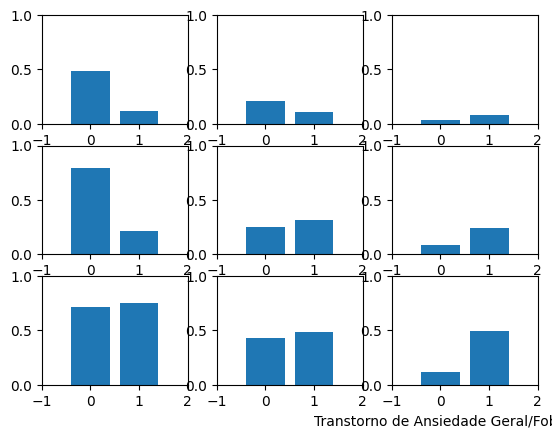

Satisfação com a vida de pessoas que possuem um mestrado:
Total:  58 %


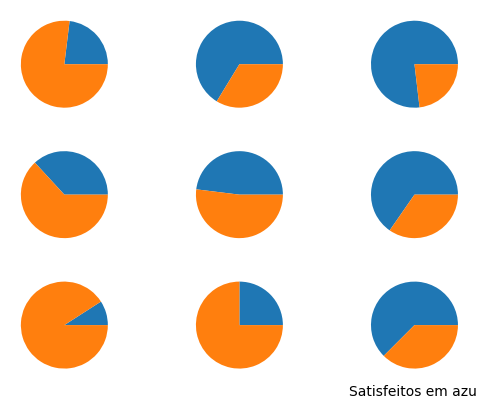

In [49]:
print('Perfil SOM com dados de anxiedade e fobia social:')
print("Ansiosos:",gadPercent(masterGAD),"%","Apresentam Fobia Social:",spinPercent(masterSPIN),"%")
mostraPesos(somMA.get_weights(), col, 3,3 )
print('Satisfação com a vida de pessoas que possuem um mestrado:')
masterP = swlPercent(masterSWL)
print("Total: ",masterP,"%")
plotSatisfactionProfiles(MmasterT, MmasterS)

**Doutores**:

Perfil SOM com dados de anxiedade e fobia social:
Ansiosos: 29 % Apresentam Fobia Social: 24 %


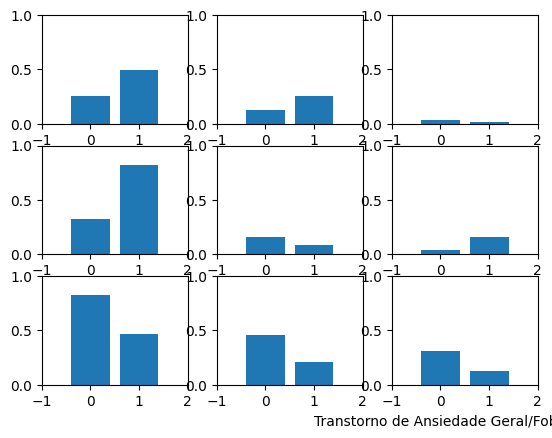

Satisfação com a vida de pessoas que possuem um doutorado / pós doutorado:
Total:  66 %


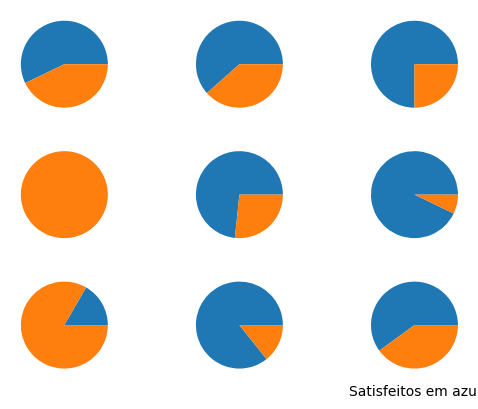

In [50]:
print('Perfil SOM com dados de anxiedade e fobia social:')
print("Ansiosos:",gadPercent(phdGAD),"%","Apresentam Fobia Social:",spinPercent(phdSPIN),"%")
mostraPesos(somPD.get_weights(), cl, 3,3 )
print('Satisfação com a vida de pessoas que possuem um doutorado / pós doutorado:')
phdP = swlPercent(phdSWL)
print("Total: ",phdP,"%")
plotSatisfactionProfiles(MphdT, MphdS)

Ensino médio completo:

Perfil SOM com dados de anxiedade e fobia social:
Ansiosos: 32 % Apresentam Fobia Social: 32 %


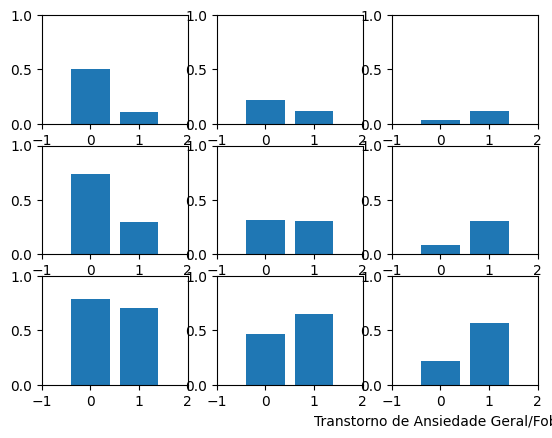

Satisfação com a vida de pessoas que possuem o grau escolar:
Total:  44 %


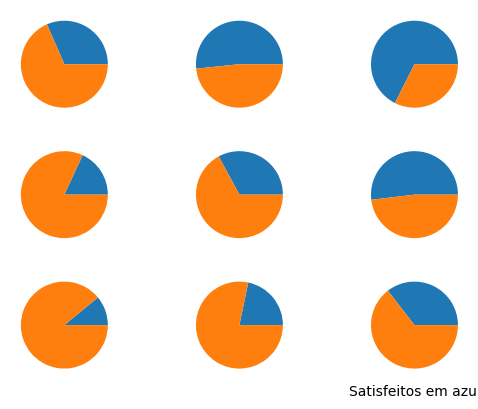

In [51]:
print('Perfil SOM com dados de anxiedade e fobia social:')
print("Ansiosos:",gadPercent(hschoolGAD),"%","Apresentam Fobia Social:",spinPercent(hschoolSPIN),"%")
mostraPesos(somHS.get_weights(), cols, 3,3 )
print('Satisfação com a vida de pessoas que possuem o grau escolar:')
hschoolP = swlPercent(hschoolSWL)
print("Total: ",hschoolP,"%")
plotSatisfactionProfiles(MhschoolT, MhschoolS)

Sem grau de escolaridade / Ensino médio incompleto:

Perfil SOM com dados de anxiedade e fobia social:
Ansiosos: 32 % Apresentam Fobia Social: 36 %


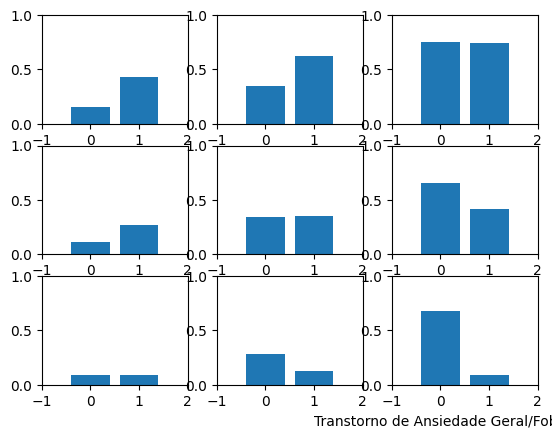

Satisfação com a vida de pessoas que não possuem grau de escolaridade:
Total:  47 %


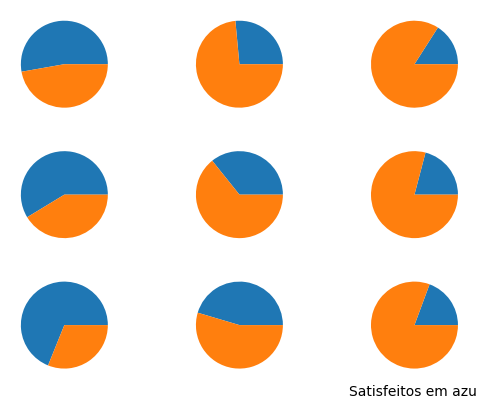

In [52]:
print('Perfil SOM com dados de anxiedade e fobia social:')
print("Ansiosos:",gadPercent(degreenoneGAD),"%","Apresentam Fobia Social:",spinPercent(degreenoneSPIN),"%")
mostraPesos(somDN.get_weights(), cls, 3,3 )
print('Satisfação com a vida de pessoas que não possuem grau de escolaridade:')
degreenoneP = swlPercent(degreenoneSWL)
print("Total: ",degreenoneP,"%")
plotSatisfactionProfiles(MdegreenoneT, MdegreenoneS)


#Conclusões:

Apesar da grande maiora dos entrevistados serem homens jovens que jogam league of legends pelo computador, foi possível verificar tendências nos resultados:

- Pessoas que apresentam dificuldade para não jogar durante o trabalho / estudo apresentam as maiores taxas de ansiedade (93%) e fobia social (67%)

- Quanto maior o grau de escolaridade, maior a satisfação com a vida (maior taxa de SWL: Doutores com 66%)

- Pessoas desempregadas, sem nível de escolaridade ou com apenas o ensino médio completo tendem a ter maiores taxas de fobia social (todos acima de 40%) 


